# **Project UAS Kecerdasan Buatan**

## **Library**

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pygad
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

## **Data**

In [2]:
data = pd.read_csv('adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
X = data.drop('income', axis=1)
y = data['income']

## **EDA**

In [4]:
data[data == '?'] = np.nan
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [5]:
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

## **Preprocessing**

### **Train Test Split**

In [6]:
X_train, X_val, y_train, y_val = train_test_split(data.drop('income', axis=1), data['income'], test_size=0.2, random_state=42)

### **Encoding**

In [7]:
# Encode categorical features in X_train and X_val
categorical_cols = X_train.select_dtypes(include=['object']).columns

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on all data (train + val) to handle unseen labels
    all_values = pd.concat([X_train[col], X_val[col]], axis=0).astype(str)
    le.fit(all_values)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_val[col] = le.transform(X_val[col].astype(str))
    le_dict[col] = le

# Encode target variable if needed
target_le = LabelEncoder()
y_train = target_le.fit_transform(y_train)
y_val = target_le.transform(y_val)

### **Handling Missing Values**

In [8]:
data.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [9]:
print(data["occupation"].value_counts())

occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: count, dtype: int64


In [10]:
data["workclass"].replace(np.nan, "Private", inplace=True)
data["occupation"].replace(np.nan, "Sales", inplace=True)
data["native.country"].replace(np.nan, "United-States", inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_12388\2765059703.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["workclass"].replace(np.nan, "Private", inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_12388\2765059703.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [11]:
train_data = X_train.copy()
train_data['income'] = y_train

majority_class = train_data[train_data['income'] == 0]
minority_class = train_data[train_data['income'] == 1]

minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

balanced_train_data = pd.concat([majority_class, minority_upsampled])

X_train_balanced = balanced_train_data.drop('income', axis=1)
y_train_balanced = balanced_train_data['income']

In [12]:
balanced_train_data['income'].value_counts()

income
0    19744
1    19744
Name: count, dtype: int64

### **Scaling**

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)

## **Modelling**

In [14]:
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_scaled, y_train_balanced)
y_pred_dt = model_dt.predict(X_val_scaled)

print("Decision Tree Accuracy:", accuracy_score(y_val, y_pred_dt.round()))

Decision Tree Accuracy: 0.8185168125287886


In [15]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_scaled, y_train_balanced)
y_pred_knn = model_knn.predict(X_val_scaled)

print("KNN Accuracy:", accuracy_score(y_val, y_pred_knn.round()))
print()

KNN Accuracy: 0.7724550898203593



## **Optimization**

### **Genetic Algorithm**

In [16]:
class GAHyperparameterTuner:
    def __init__(self, X_train, y_train, model_type='dt', X_val=None, y_val=None, cv=3):
        """
        Inisialisasi tuner hyperparameter dengan Genetic Algorithm menggunakan PyGAD
        
        Parameters:
        -----------
        X_train : Data fitur training
        y_train : Label training
        model_type : Tipe model ('dt' untuk Decision Tree, 'knn' untuk K-Nearest Neighbors)
        X_val : Data fitur validasi (opsional)
        y_val : Label validasi (opsional)
        cv : Jumlah fold untuk cross-validation
        """
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.cv = cv
        self.model_type = model_type.lower()
        self.best_solution = None
        self.best_params = None
        self.fitness_history = []
        
        # Definisikan parameter bounds berdasarkan tipe model
        if self.model_type == 'dt':
            self.param_bounds = {
                'max_depth': (3, 30, 1),              # Integer parameter
                'min_samples_split': (2, 20, 1),      # Integer parameter
                'min_samples_leaf': (1, 20, 1),       # Integer parameter
                'max_features': (0.1, 1.0, 0.05),     # Float parameter (proportion)
                'criterion': (0, 1, 1)                # Categorical: 0=gini, 1=entropy
            }
        elif self.model_type == 'knn':
            self.param_bounds = {
                'n_neighbors': (1, 30, 1),            # Integer parameter
                'weights': (0, 1, 1),                 # Categorical: 0=uniform, 1=distance
                'p': (1, 2, 1),                       # Integer parameter (Manhattan=1, Euclidean=2)
                'leaf_size': (10, 50, 1)              # Integer parameter
            }
        else:
            raise ValueError("model_type harus 'dt' atau 'knn'")
        
        # Menyimpan nama parameter berdasarkan urutan
        self.param_names = list(self.param_bounds.keys())
        
        # Menghitung jumlah gen berdasarkan parameter
        self.num_genes = len(self.param_bounds)
    
    def decode_solution(self, solution):
        """
        Decode solusi GA menjadi parameter yang sebenarnya
        Setiap gen (0-1) diterjemahkan ke nilai parameter berdasarkan batas yang ditentukan
        """
        params = {}
        for i, gene in enumerate(solution):
            param_name = self.param_names[i]
            min_val, max_val, step = self.param_bounds[param_name]
            
            # Decode: Mengubah nilai gen (0-1) ke nilai parameter sebenarnya
            if param_name == 'criterion' and self.model_type == 'dt':
                # Khusus untuk parameter kategorikal criterion pada Decision Tree
                value = 'gini' if gene < 0.5 else 'entropy'
            elif param_name == 'weights' and self.model_type == 'knn':
                # Khusus untuk parameter kategorikal weights pada KNN
                value = 'uniform' if gene < 0.5 else 'distance'
            elif isinstance(step, int) or step == 1:  # Integer parameter
                value = min_val + int(gene * (max_val - min_val + 1))
                value = min(value, max_val)  # Pastikan tidak melebihi max_val
            else:  # Float parameter
                value = min_val + gene * (max_val - min_val)
                # Pembulatan ke step terdekat
                value = round(value / step) * step
                # Pembulatan ke 6 desimal untuk menghindari floating point errors
                value = round(value, 6)
            
            params[param_name] = value
            
        return params
    
    def fitness_func(self, ga_instance, solution, solution_idx):
        """
        Fungsi fitness untuk evaluasi solusi GA
        """
        # Decode solusi
        params = self.decode_solution(solution)
        
        # Buat model berdasarkan tipe
        if self.model_type == 'dt':
            model = DecisionTreeClassifier(
                max_depth=None if params['max_depth'] >= 30 else int(params['max_depth']),
                min_samples_split=int(params['min_samples_split']),
                min_samples_leaf=int(params['min_samples_leaf']),
                max_features=params['max_features'] if params['max_features'] < 1.0 else None,
                criterion=params['criterion'],
                random_state=42
            )
        else:  # knn
            model = KNeighborsClassifier(
                n_neighbors=int(params['n_neighbors']),
                weights=params['weights'],
                p=int(params['p']),
                leaf_size=int(params['leaf_size'])
            )
        
        # Evaluasi model dengan cross-validation
        try:
            scores = cross_val_score(model, self.X_train, self.y_train, 
                                    cv=self.cv, scoring='accuracy')
            accuracy = np.mean(scores)
            return accuracy  # PyGAD mencari nilai fitness maksimum
        except Exception as e:
            print(f"Error evaluating solution {solution_idx}: {e}")
            return 0.0  # Return skor minimum jika error
    
    def on_generation(self, ga_instance):
        """
        Callback setiap generasi
        """
        best_solution = ga_instance.best_solution()
        best_solution_fitness = best_solution[1]
        self.fitness_history.append(best_solution_fitness)
        best_solution_params = self.decode_solution(best_solution[0])
        
        print(f"Generasi = {ga_instance.generations_completed}")
        print(f"Fitness  = {best_solution_fitness:.6f}")
        print(f"Params   = {best_solution_params}")
        print("-" * 80)
    
    def run_optimization(self, num_generations=30, num_parents_mating=5, 
                        sol_per_pop=20, mutation_probability=0.1):
        """
        Jalankan optimasi GA
        """
        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            sol_per_pop=sol_per_pop,
            num_genes=self.num_genes,
            fitness_func=self.fitness_func,
            mutation_probability=mutation_probability,
            gene_type=float,  # Semua gen adalah float (0-1)
            gene_space={'low': 0, 'high': 1},  # Range setiap gen
            on_generation=self.on_generation,
            random_seed=42
        )
        
        model_name = "Decision Tree" if self.model_type == 'dt' else "K-Nearest Neighbors"
        print(f"Memulai optimasi hyperparameter {model_name} dengan GA...")
        ga_instance.run()
        
        # Dapatkan solusi terbaik
        best_solution, best_solution_fitness, _ = ga_instance.best_solution()
        self.best_solution = best_solution
        self.best_params = self.decode_solution(best_solution)
        
        print("\nOptimasi selesai!")
        print(f"Best fitness: {best_solution_fitness:.6f}")
        print(f"Best hyperparameters untuk {model_name}:")
        for param, value in self.best_params.items():
            print(f"  {param}: {value}")
            
        return self.best_params
    
    def get_best_model(self):
        """
        Mengembalikan model yang dilatih dengan parameter terbaik
        """
        if self.best_params is None:
            print("Jalankan run_optimization() terlebih dahulu!")
            return None
        
        # Buat model dengan parameter terbaik
        if self.model_type == 'dt':
            best_model = DecisionTreeClassifier(
                max_depth=None if self.best_params['max_depth'] >= 30 else int(self.best_params['max_depth']),
                min_samples_split=int(self.best_params['min_samples_split']),
                min_samples_leaf=int(self.best_params['min_samples_leaf']),
                max_features=self.best_params['max_features'] if self.best_params['max_features'] < 1.0 else None,
                criterion=self.best_params['criterion'],
                random_state=42
            )
        else:  # knn
            best_model = KNeighborsClassifier(
                n_neighbors=int(self.best_params['n_neighbors']),
                weights=self.best_params['weights'],
                p=int(self.best_params['p']),
                leaf_size=int(self.best_params['leaf_size'])
            )
        
        # Latih model
        best_model.fit(self.X_train, self.y_train)
        
        return best_model
    
    def plot_fitness_history(self):
        """
        Plot riwayat fitness selama optimasi
        """
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.fitness_history) + 1), self.fitness_history, 
                marker='o', linestyle='-', color='#2980b9')
        plt.title(f'Progression of Best Fitness Score for {self.model_type.upper()} Across Generations', 
                fontsize=14)
        plt.xlabel('Generation', fontsize=12)
        plt.ylabel('Best Fitness (Accuracy)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        return plt

#### Optimizing Decision Tree

OPTIMASI MODEL DECISION TREE DENGAN GENETIC ALGORITHM
Memulai optimasi hyperparameter Decision Tree dengan GA...
Generasi = 1
Fitness  = 0.894272
Params   = {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.85, 'criterion': 'gini'}
--------------------------------------------------------------------------------
Generasi = 2
Fitness  = 0.894272
Params   = {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.85, 'criterion': 'gini'}
--------------------------------------------------------------------------------
Generasi = 3
Fitness  = 0.894373
Params   = {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'criterion': 'gini'}
--------------------------------------------------------------------------------
Generasi = 4
Fitness  = 0.897235
Params   = {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.85, 'criterion': 'gini'}
-------------------------------------

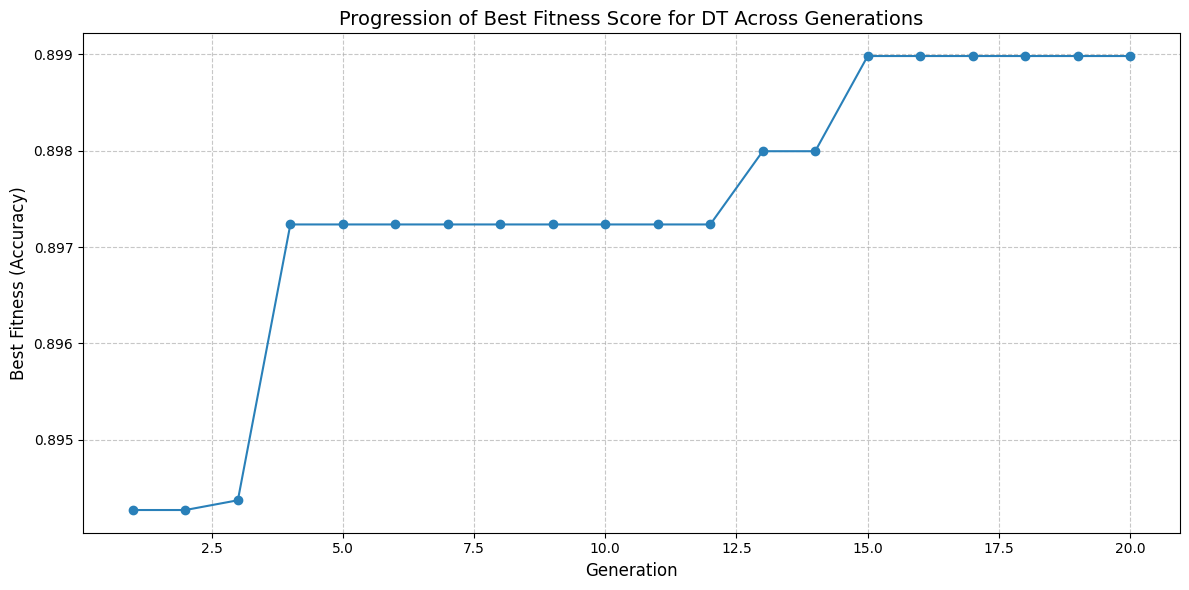

In [17]:
print("=" * 80)
print("OPTIMASI MODEL DECISION TREE DENGAN GENETIC ALGORITHM")
print("=" * 80)

dt_tuner = GAHyperparameterTuner(
    X_train=X_train_scaled, 
    y_train=y_train_balanced,
    model_type='dt',  # Decision Tree
    cv=3  # 3-fold cross-validation
)

# Jalankan optimasi GA untuk Decision Tree
dt_best_params = dt_tuner.run_optimization(
    num_generations=20,       # Jumlah generasi (bisa disesuaikan)
    num_parents_mating=5,     # Jumlah parent untuk reproduksi
    sol_per_pop=20,           # Ukuran populasi
    mutation_probability=0.15 # Probabilitas mutasi
)

# Dapatkan model DT terbaik hasil optimasi GA
dt_best_model = dt_tuner.get_best_model()

# Evaluasi model pada data validasi
y_pred_dt_ga = dt_best_model.predict(X_val_scaled)
dt_ga_accuracy = accuracy_score(y_val, y_pred_dt_ga)

print("\nHasil evaluasi Decision Tree dengan hyperparameter optimal dari GA:")
print(f"Accuracy: {dt_ga_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_dt_ga, target_names=target_le.classes_))

# Plot riwayat fitness
dt_plot = dt_tuner.plot_fitness_history()
dt_plot.savefig('dt_ga_fitness_history.png', dpi=300, bbox_inches='tight')
dt_plot.show()

#### Optimizing KNN




OPTIMASI MODEL KNN DENGAN GENETIC ALGORITHM
Memulai optimasi hyperparameter K-Nearest Neighbors dengan GA...
Generasi = 1
Fitness  = 0.897083
Params   = {'n_neighbors': 2, 'weights': 'distance', 'p': 1, 'leaf_size': 31}
--------------------------------------------------------------------------------
Generasi = 2
Fitness  = 0.897083
Params   = {'n_neighbors': 2, 'weights': 'distance', 'p': 1, 'leaf_size': 31}
--------------------------------------------------------------------------------
Generasi = 3
Fitness  = 0.897083
Params   = {'n_neighbors': 2, 'weights': 'distance', 'p': 1, 'leaf_size': 31}
--------------------------------------------------------------------------------
Generasi = 4
Fitness  = 0.897083
Params   = {'n_neighbors': 2, 'weights': 'distance', 'p': 1, 'leaf_size': 31}
--------------------------------------------------------------------------------
Generasi = 5
Fitness  = 0.897083
Params   = {'n_neighbors': 2, 'weights': 'distance', 'p': 1, 'leaf_size': 31}
---------

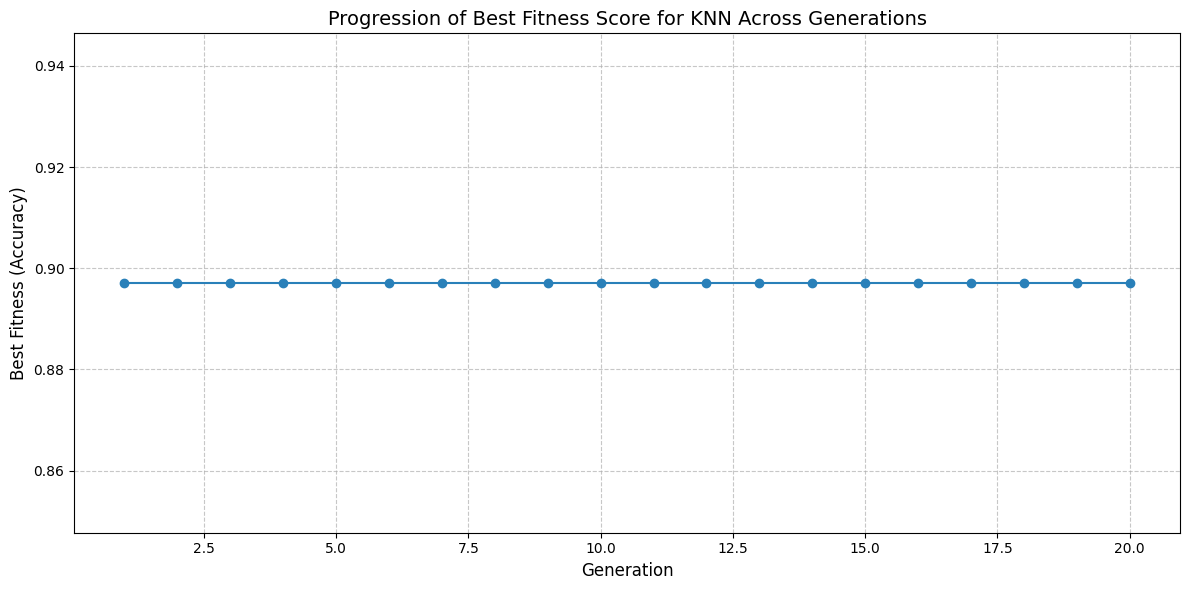

In [18]:
print("\n\n")
print("=" * 80)
print("OPTIMASI MODEL KNN DENGAN GENETIC ALGORITHM")
print("=" * 80)

knn_tuner = GAHyperparameterTuner(
    X_train=X_train_scaled, 
    y_train=y_train_balanced,
    model_type='knn',  # K-Nearest Neighbors
    cv=3  # 3-fold cross-validation
)

# Jalankan optimasi GA untuk KNN
knn_best_params = knn_tuner.run_optimization(
    num_generations=20,       # Jumlah generasi
    num_parents_mating=5,     # Jumlah parent untuk reproduksi
    sol_per_pop=20,           # Ukuran populasi
    mutation_probability=0.15 # Probabilitas mutasi
)

# Dapatkan model KNN terbaik hasil optimasi GA
knn_best_model = knn_tuner.get_best_model()

# Evaluasi model pada data validasi
y_pred_knn_ga = knn_best_model.predict(X_val_scaled)
knn_ga_accuracy = accuracy_score(y_val, y_pred_knn_ga)

print("\nHasil evaluasi KNN dengan hyperparameter optimal dari GA:")
print(f"Accuracy: {knn_ga_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_knn_ga, target_names=target_le.classes_))

# Plot riwayat fitness
knn_plot = knn_tuner.plot_fitness_history()
knn_plot.savefig('knn_ga_fitness_history.png', dpi=300, bbox_inches='tight')
knn_plot.show()

#### Model Comparison
Bandingkan akurasi semua model (original vs GA-optimized)

C:\Users\HP\AppData\Local\Temp\ipykernel_12388\1362915762.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models, y=accuracies, palette=colors)


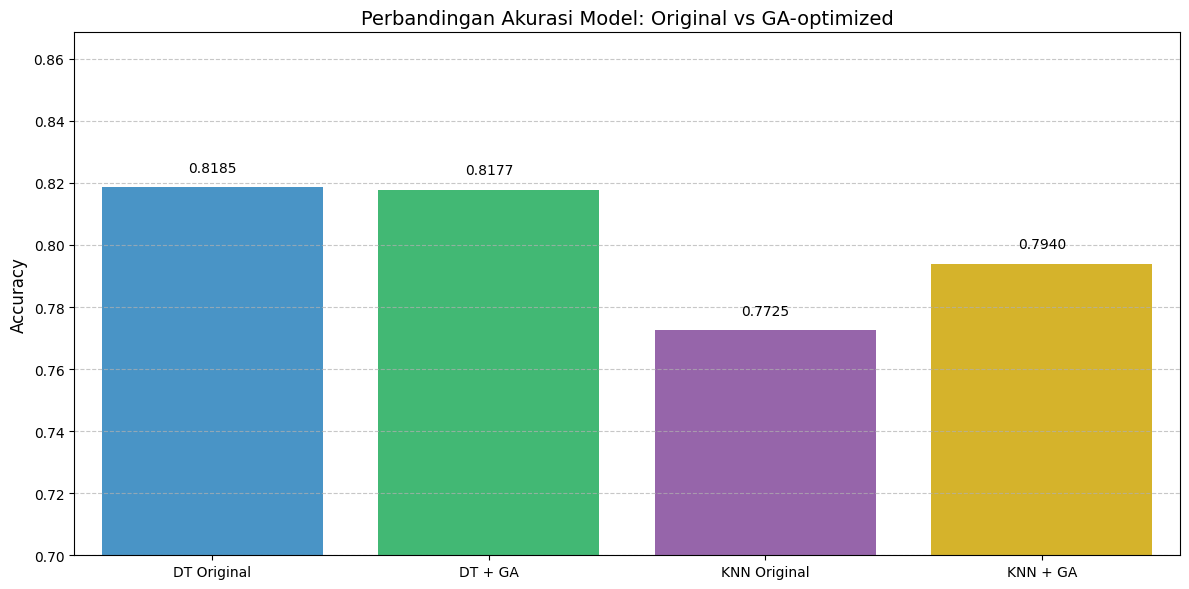


RINGKASAN HASIL OPTIMASI

Decision Tree:
  Original Accuracy: 0.8185
  GA Optimized Accuracy: 0.8177
  Improvement: -0.08%
  Best Parameters:
    - max_depth: 26
    - min_samples_split: 2
    - min_samples_leaf: 1
    - max_features: 0.85
    - criterion: gini

KNN:
  Original Accuracy: 0.7725
  GA Optimized Accuracy: 0.7940
  Improvement: 2.15%
  Best Parameters:
    - n_neighbors: 2
    - weights: distance
    - p: 1
    - leaf_size: 16


In [19]:
models = ['DT Original', 'DT + GA', 'KNN Original', 'KNN + GA']
accuracies = [
    accuracy_score(y_val, y_pred_dt.round()),  # DT Original (dari notebook asli)
    dt_ga_accuracy,                           # DT + GA
    accuracy_score(y_val, y_pred_knn.round()), # KNN Original (dari notebook asli)
    knn_ga_accuracy                           # KNN + GA
]

plt.figure(figsize=(12, 6))
colors = ['#3498db', '#2ecc71', '#9b59b6', '#f1c40f']
ax = sns.barplot(x=models, y=accuracies, palette=colors)
plt.title('Perbandingan Akurasi Model: Original vs GA-optimized', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.70, max(accuracies) + 0.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan label nilai akurasi di atas bar
for i, acc in enumerate(accuracies):
    ax.text(i, acc + 0.005, f'{acc:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Simpan hasil parameter terbaik
results = {
    'Decision Tree': {
        'Original Accuracy': accuracy_score(y_val, y_pred_dt.round()),
        'GA Optimized Accuracy': dt_ga_accuracy,
        'Improvement': (dt_ga_accuracy - accuracy_score(y_val, y_pred_dt.round())) * 100,
        'Best Parameters': dt_best_params
    },
    'KNN': {
        'Original Accuracy': accuracy_score(y_val, y_pred_knn.round()),
        'GA Optimized Accuracy': knn_ga_accuracy,
        'Improvement': (knn_ga_accuracy - accuracy_score(y_val, y_pred_knn.round())) * 100,
        'Best Parameters': knn_best_params
    }
}

# Tampilkan ringkasan hasil
print("\n" + "=" * 80)
print("RINGKASAN HASIL OPTIMASI")
print("=" * 80)

for model, result in results.items():
    print(f"\n{model}:")
    print(f"  Original Accuracy: {result['Original Accuracy']:.4f}")
    print(f"  GA Optimized Accuracy: {result['GA Optimized Accuracy']:.4f}")
    print(f"  Improvement: {result['Improvement']:.2f}%")
    print("  Best Parameters:")
    for param, value in result['Best Parameters'].items():
        print(f"    - {param}: {value}")

### **Particle Swarm Optimization**

##  **Evaluation**